In [254]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar, dtypes
from graphblas import unary, binary, monoid, semiring
from graphblas.io import mmread
from typing import List

# №1. Используя python-graphblas реализовать функцию поиска кратчайших путей в ориентированном графе из заданной вершины (Bellman–Ford). <br> Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и номер стартовой вершины. <br> Функция возвращает массив, где для каждой вершины указано расстояние до неё от указанной стартовой вершины. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

## Везде ниже:<br> push_pull_percent == 0 -> push <br> push_pull_percent == 1 -> pull <br> push_pull_percent == 0.3 -> push если степень разреженности фронта 0.3, иначе pull

In [241]:
def bellman_ford(A: Matrix, vertex: int, push_pull_percent=0.0) -> Vector:
    n = A.nrows
    v = Vector(dtypes.INT64, n)
    v[vertex] << 0
    w = v.dup()
    for _ in range(n - 1):
        last_w = w.dup()
        if push_pull_percent == 0.0:
            w(binary.min) << w.vxm(A, semiring.min_plus)
        elif push_pull_percent == 1.0:
            w(binary.min) << A.T.mxv(w, semiring.min_plus)
        else:
            if w.nvals / w.size > push_pull_percent:
                w(binary.min) << A.T.mxv(w, semiring.min_plus)
            else:
                w(binary.min) << w.vxm(A, semiring.min_plus)
        if w.isequal(last_w):
            break
      
    last_w = w.dup()
    if push_pull_percent == 0.0:
        w(binary.min) << w.vxm(A, semiring.min_plus)
    elif push_pull_percent == 1.0:
        w(binary.min) << A.T.mxv(w, semiring.min_plus)
    else:
        if w.nvals / w.size > push_pull_percent:
            w(binary.min) << A.T.mxv(w, semiring.min_plus)
        else:
            w(binary.min) << w.vxm(A, semiring.min_plus)
    if not w.isequal(last_w):
        return "Присутсвует цикл отрицательного веса"

    result = Vector(dtypes.FP64, n)
    for i in range(n):
        if w[i].value is None:
            result[i] << float('inf')
        else:
            result[i] << w[i]
    return result

# №2. Используя python-graphblas реализовать функцию поиска кратчайших путей в ориентированном графе из нескольких заданных вершин, модифицировав предыдущий алгоритм. <br>  Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин. <br>  Функция возвращает массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [234]:
def mult_bellman_ford(A: Matrix, start_vertices: List[int], push_pull_percent=0.0) -> Matrix:
    n = A.ncols
    number_of_start_vertex = len(start_vertices)
    f = Matrix(dtypes.INT64, number_of_start_vertex, n)
    for ind, val in enumerate(start_vertices):
        f[ind, val] << 0
    w = f.dup()
    for _ in range(n - 1):
        last_w = w.dup()
        for i in range(number_of_start_vertex):
            if push_pull_percent == 0.0:
                w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
            elif push_pull_percent == 1.0:
                w[i, :](binary.min) << A.T.mxv(w[i, :], semiring.min_plus)
            else:
                if w[i, :].nvals / w[i, :].size > push_pull_percent:
                    w[i, :](binary.min) << A.T.mxv(w[i, :], semiring.min_plus)
                else:
                    w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)         
        if w.isequal(last_w):
            break

    last_w = w.dup()
    for i in range(number_of_start_vertex):
        if push_pull_percent == 0.0:
            w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
        elif push_pull_percent == 1.0:
            w[i, :](binary.min) << A.T.mxv(w[i, :], semiring.min_plus)
        else:
            if w[i, :].nvals / w[i, :].size > push_pull_percent:
                w[i, :](binary.min) << A.T.mxv(w[i, :], semiring.min_plus)
            else:
                w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
    if not w.isequal(last_w):
        return "Присутсвует цикл отрицательного веса"

    result = Matrix(dtypes.FP64, number_of_start_vertex, n)
    for i in range(number_of_start_vertex):
        for j in range(n):
            if w[i,j].value is None:
                result[i,j] << float('inf')
            else:
                result[i,j] << w[i,j]
    return result

# №3. Используя python-graphblas реализовать две функции поиска кратчайших путей в ориентированном графе для всех пар вершин (Floyd–Warshall и вычисление транзитивного замыкания). <br> Функции принимают представление графа, удобное для неё (загрузка, конвертация реализованы отдельно). <br> Функции возвращают массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [235]:
def floyd_warshall(A: Matrix) -> Matrix:
    n = A.nrows
    w = A.dup()
    for k in range(n):
        w_c = Matrix(dtypes.INT64, n, n)
        w_r = Matrix(dtypes.INT64, n, n)
        w_c[:,k] = w[:,k].dup()
        w_r[k,:] = w[k,:].dup()
        w(binary.min) << w_c.mxm(w_r.dup(), semiring.min_plus)

    last_w = w.dup()
    w_c = Matrix(dtypes.INT64, n, n)
    w_r = Matrix(dtypes.INT64, n, n)
    w_c[:,k] = w[:,k].dup()
    w_r[k,:] = w[k,:].dup()
    w(binary.min) << w_c.mxm(w_r.dup(), semiring.min_plus)
    if not w.isequal(last_w):
        return "Присутсвует цикл отрицательного веса"

    result = Matrix(dtypes.FP64, n, n)
    for i in range(n):
        for j in range(n):
            if w[i,j].value is None:
                result[i,j] << float('inf')
            else:
                result[i,j] << w[i,j]
    return result

def transitive_closure(A: Matrix) -> Matrix:
    n = A.nrows
    w = A.dup()
    for i in range(n):
        w(binary.min) << w.mxm(w, semiring.min_plus)

    last_w = w.dup()
    w(binary.min) << w.mxm(w, semiring.min_plus)
    if not w.isequal(last_w):
        return "Присутсвует цикл отрицательного веса"
        
    result = Matrix(dtypes.FP64, n, n)
    for i in range(n):
        for j in range(n):
            if w[i,j].value is None:
                result[i,j] << float('inf')
            else:
                result[i,j] << w[i,j]
    return result

# А теперь тесты...

In [267]:
def test(A: Matrix, print_flag=False, n_vertices=20):
    s1 = np.random.randint(0, A.ncols)
    s2 = np.random.randint(0, A.ncols, n_vertices)
    print(f'Вершина для bellman_ford: {s1}; вершины для mult_bellman_ford: {s2}')
    if print_flag:
        result = [bellman_ford(A, s1), mult_bellman_ford(A, s2), floyd_warshall(A), transitive_closure(A)]
        for ind, algo_name in enumerate(['bellman_ford:', 'mult_bellman_ford:', 'floyd_warshall:', 'transitive_closure:']):
            print(algo_name, result[ind], end='; ')
    print('bellman_ford:')
    %timeit bellman_ford(A, s1)
    
    print('mult_bellman_ford:')
    %timeit mult_bellman_ford(A, s2)
    
    print('floyd_warshall:')
    %timeit floyd_warshall(A)
    
    print('transitive_closure:')
    %timeit transitive_closure(A)

In [237]:
data = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
    [3, 2, 3, 1, 5, 3, 7, 8, 3, 1, 7, 4],
]
rows, cols, weights = data
M1 = Matrix.from_coo(rows, cols, weights)

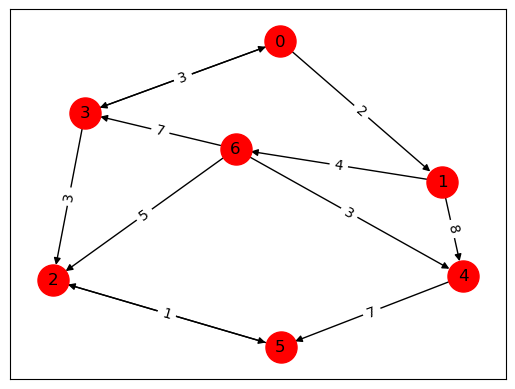

In [238]:
gb.viz.draw(M1)

In [246]:
test(M1, True, 3)

Вершина для bellman_ford: 1; вершины для mult_bellman_ford: [5 0 5]
bellman_ford: "v_2550954"  nvals  size  dtype  format
gb.Vector        7     7   FP64  bitmap
---------------------------------------
index     0    1    2     3    4     5    6
value  14.0  0.0  9.0  11.0  7.0  10.0  4.0; mult_bellman_ford: "M_514568"  nvals  nrows  ncols  dtype   format
gb.Matrix      21      3      7   FP64  bitmapr
-----------------------------------------------
     0    1    2    3    4    5    6
0  inf  inf  1.0  inf  inf  0.0  inf
1  0.0  2.0  6.0  3.0  9.0  7.0  6.0
2  inf  inf  1.0  inf  inf  0.0  inf; floyd_warshall: "M_514595"  nvals  nrows  ncols  dtype   format
gb.Matrix      49      7      7   FP64  bitmapr
-----------------------------------------------
      0     1    2     3     4     5     6
0   6.0   2.0  6.0   3.0   9.0   7.0   6.0
1  14.0  16.0  9.0  11.0   7.0  10.0   4.0
2   inf   inf  2.0   inf   inf   1.0   inf
3   3.0   5.0  3.0   6.0  12.0   4.0   9.0
4   inf   inf  8.0   i

In [247]:
data = [
    [0, 1, 1, 2, 3],
    [3, 0, 2, 3, 1],
    [2, 3, -2, -5, -1],
]
rows, cols, weights = data
M2 = Matrix.from_coo(rows, cols, weights)
M2

"M_625717"  nvals  nrows  ncols  dtype   format
gb.Matrix       5      4      4  INT64  bitmapr
-----------------------------------------------
   0   1   2   3
0              2
1  3      -2    
2             -5
3     -1

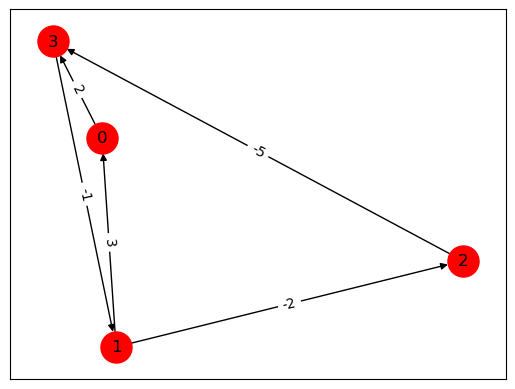

In [163]:
gb.viz.draw(M2)

In [248]:
test(M2, True, 3)

Вершина для bellman_ford: 0; вершины для mult_bellman_ford: [3 0 0]
bellman_ford: Присутсвует цикл отрицательного веса; mult_bellman_ford: Присутсвует цикл отрицательного веса; floyd_warshall: Присутсвует цикл отрицательного веса; transitive_closure: Присутсвует цикл отрицательного веса; bellman_ford:
83.7 µs ± 60.9 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
mult_bellman_ford:
670 µs ± 545 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
floyd_warshall:
550 µs ± 4.74 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
transitive_closure:
63 µs ± 240 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Все работает корректно, видно что на малых графах довольно выгодно пользоваться транзитивным замыканием 

# №4. (+3 балла) Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате Matrix Market с сайта SuiteSparse Matrix Collection и на случайных сгенерированных. При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количестве стартовых вершин. В частности выяснить, начиная с какой доли вершин в графе целесообразнее использовать алгоритм поиска кратчайших путей для всех пар вершин вместо того, чтобы решать задачу поиска кратчайших путей из нескольких стартовых (модифицированный Bellman-Ford).

In [268]:
import os
count = 0
files = ['494_bus.mtx', 'arc130.mtx']
for file in files:
    matrix = mmread(f'./Графы_ИТМО/матрицы/{file}')
    print(f'name: {file}; nvals: {matrix.nvals}, nrows: {matrix.nrows}, ncols: {matrix.ncols}')
    test(matrix, False)
    print()

name: 494_bus.mtx; nvals: 1666, nrows: 494, ncols: 494
Вершина для bellman_ford: 309; вершины для mult_bellman_ford: [246 231 321 122  68 434  18 188 201 281 229 305 321 440 408 179 143 492
 417 200]
bellman_ford:
21.6 ms ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
mult_bellman_ford:
691 ms ± 957 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
floyd_warshall:
7.56 s ± 27.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
transitive_closure:
7.29 s ± 23.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

name: arc130.mtx; nvals: 1282, nrows: 130, ncols: 130
Вершина для bellman_ford: 53; вершины для mult_bellman_ford: [ 26  90  29  84  82  48  22   9  52   3   5 123  88  30  56  47  89   1
  95  94]
bellman_ford:
4.92 ms ± 3.22 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
mult_bellman_ford:
149 ms ± 480 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
floyd_warshall:
528 ms ± 3.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [269]:
def generate_random_graph(n, density):
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if np.random.rand() < density:
                matrix[i-1, j-1] = 1
    np.fill_diagonal(matrix, 0)
    matrix += matrix.T
    matrix = Matrix.from_dense(matrix, missing_value=0.0)
    return matrix

In [ ]:
for i in [50, 100, 200, 500, 1000]:
  print(f'Количество вершин: {i}, плотность: 0.1, количество стартовых вершин: 20')
  random_graph = generate_random_graph(i, 0.1)
  print(f'nvals: {random_graph.nvals}, nrows: {random_graph.nrows}, ncols: {random_graph.ncols}')
  test(random_graph, False)
  print()

Количество вершин: 50, плотность: 0.1, количество стартовых вершин: 20
nvals: 248, nrows: 50, ncols: 50
Вершина для bellman_ford: 28; вершины для mult_bellman_ford: [10 16 33 11 20 10  0 10  4  0 26 23  4  4 24 19 22  6 36 17]
bellman_ford:
1.25 ms ± 1.88 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
mult_bellman_ford:
38.9 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
floyd_warshall:
79.5 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
transitive_closure:
85.1 ms ± 303 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Количество вершин: 100, плотность: 0.1, количество стартовых вершин: 20
nvals: 968, nrows: 100, ncols: 100
Вершина для bellman_ford: 72; вершины для mult_bellman_ford: [19 89 95 75 22 62 39 42 65 76  8 13 26 51 46 93 13 20 42 49]
bellman_ford:
2.34 ms ± 5.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
mult_bellman_ford:
67.6 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
floyd_warshall:

# Уже даже на небольших графах довольно долго работают алгоритмы Флойда Уоршелла и транзитивное замыкание, я также запускал на графах с еще бОльшим числом вершин, но это занимает очень много времени. Также видно, что быстрее будет запустить алгоритм беллмана форда 20 раз по одной вершине, чем сразу на 20, однако с ростом числа стартовых вершин лучше запускать сразу модифицированный алгоритм (P.S. Недождался транзитивное замыкание)

# №5. (+2 балла) Оценить эффект от использования push/pull direction optimization для векторно-матричных операциях в алгоритмах. Попробовать разные стратегии (всегда push, всегда pull, использовать порог наполненности вектора и т.д.).

In [277]:
random_graph = generate_random_graph(1000, 0.4)
for i in [0.0, 0.1, 0.3, 0.7, 1.0]:
  print(f'Количество вершин: 1000, плотность: 0.4, количество стартовых вершин: 20, уровень push/pull: {i}')
  print(f'nvals: {random_graph.nvals}, nrows: {random_graph.nrows}, ncols: {random_graph.ncols}')
  %timeit mult_bellman_ford(random_graph, range(0, 20), i)
  print()

Количество вершин: 1000, плотность: 0.4, количество стартовых вершин: 20, уровень push/pull: 0.0
nvals: 399728, nrows: 1000, ncols: 1000
673 ms ± 4.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 1000, плотность: 0.4, количество стартовых вершин: 20, уровень push/pull: 0.1
nvals: 399728, nrows: 1000, ncols: 1000
681 ms ± 4.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 1000, плотность: 0.4, количество стартовых вершин: 20, уровень push/pull: 0.3
nvals: 399728, nrows: 1000, ncols: 1000
677 ms ± 8.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 1000, плотность: 0.4, количество стартовых вершин: 20, уровень push/pull: 0.7
nvals: 399728, nrows: 1000, ncols: 1000
681 ms ± 2.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 1000, плотность: 0.4, количество стартовых вершин: 20, уровень push/pull: 1.0
nvals: 399728, nrows: 1000, ncols: 1000
672 ms ± 6.54 ms per loop (mean ± std. de

In [279]:
random_graph = generate_random_graph(1000, 0.4)
for i in [0.0, 0.1, 0.3, 0.7, 1.0]:
  print(f'Количество вершин: 1000, плотность: 0.4, уровень push/pull: {i}')
  print(f'nvals: {random_graph.nvals}, nrows: {random_graph.nrows}, ncols: {random_graph.ncols}')
  %timeit bellman_ford(random_graph, np.random.randint(0, random_graph.nrows), i)
  print()

Количество вершин: 1000, плотность: 0.4, уровень push/pull: 0.0
nvals: 399704, nrows: 1000, ncols: 1000
24.9 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Количество вершин: 1000, плотность: 0.4, уровень push/pull: 0.1
nvals: 399704, nrows: 1000, ncols: 1000
24.7 ms ± 66.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Количество вершин: 1000, плотность: 0.4, уровень push/pull: 0.3
nvals: 399704, nrows: 1000, ncols: 1000
24.8 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Количество вершин: 1000, плотность: 0.4, уровень push/pull: 0.7
nvals: 399704, nrows: 1000, ncols: 1000
24.9 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Количество вершин: 1000, плотность: 0.4, уровень push/pull: 1.0
nvals: 399704, nrows: 1000, ncols: 1000
24.9 ms ± 70.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)



# В данном случае видно, что pull реализация работает либо также, либо чуть быстрее